# Coral Bleaching Severity Predictive Model
Using the global coral bleaching database from van Woesik, R., Burkepile, D., I intend to write a model which can predict the severity of the bleaching based on a variety of collected factors, including location, percent cover, temperature, and more.

Citation:
van Woesik, R., Burkepile, D. (2022) Bleaching and environmental data for global coral reef sites from 1980-2020. Biological and Chemical Oceanography Data Management Office (BCO-DMO). (Version 2) Version Date 2022-10-14

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
coral = pd.read_csv('data/global_bleaching_environmental.csv')

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (13,15,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Exploration

In [117]:
coral.shape

(41361, 62)

In [118]:
coral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                41361 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41361 non-null  object 
 9   Country_Name                           41361 non-null  object 
 10  State_Island_Province_Name             41361 non-null  object 
 11  Ci

While it appears that there are no null values in this dataframe, this is untrue. The null data is encoded as "nd" instead of a NaN value. 

In [119]:
coral = coral.replace('nd', np.nan)

In [120]:
coral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                28821 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41358 non-null  object 
 9   Country_Name                           41360 non-null  object 
 10  State_Island_Province_Name             41262 non-null  object 
 11  Ci

In [121]:
coral.columns

Index(['Site_ID', 'Sample_ID', 'Data_Source', 'Latitude_Degrees',
       'Longitude_Degrees', 'Ocean_Name', 'Reef_ID', 'Realm_Name',
       'Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name',
       'City_Town_Name', 'Site_Name', 'Distance_to_Shore', 'Exposure',
       'Turbidity', 'Cyclone_Frequency', 'Date_Day', 'Date_Month', 'Date_Year',
       'Depth_m', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level',
       'Percent_Bleaching', 'ClimSST', 'Temperature_Kelvin',
       'Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation', 'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Freq

## Data Cleaning

Off the bat, many of these columns contain summary statistics related to the data collection process. For the purpose of this project, I will trust the values calculated by the original data source. As such, I will drop the extraneous columns to uncomplicate the dataframe.

In [122]:
coral.drop(['Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
            'Temperature_Kelvin_Standard_Deviation', 'SSTA_Standard_Deviation', 
            'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum','SSTA_Frequency_Standard_Deviation',
            'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW_Standard_Deviation', 
            'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA_Standard_Deviation', 'TSA_Minimum', 
            'TSA_Maximum', 'TSA_Mean', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
            'TSA_FrequencyMean', 'TSA_DHW_Standard_Deviation', 'TSA_DHWMax', 'TSA_DHWMean'],
           axis=1, inplace=True)

While many of these columns contain float datatypes, they are encoded as object types. 

In [123]:
float_cols = ['Percent_Cover', 'Percent_Bleaching', 'Distance_to_Shore', 'Turbidity', 
              'Depth_m', 'ClimSST', 'Temperature_Kelvin', 'Windspeed', 'SSTA', 
              'SSTA_Frequency', 'SSTA_DHW', 'TSA', 'TSA_Frequency', 'TSA_DHW']

for col in float_cols:
    coral.loc[:, [col]] = coral.loc[:, col].astype(float)

Since we will be predicting a categorical variable defined by the column Percent_Bleaching, I will drop any rows without a value for this variable.

In [124]:
coral = coral.dropna(subset=['Percent_Bleaching'])

In [125]:
[f"{col}: {coral[col].count()}" for col in coral.columns if (coral[col].count()/len(coral))<=.67]

['Reef_ID: 22531',
 'Site_Name: 6871',
 'Substrate_Name: 22468',
 'Percent_Cover: 22673',
 'Bleaching_Level: 22531',
 'Site_Comments: 2070',
 'Sample_Comments: 2763',
 'Bleaching_Comments: 2669']

The list of columns above have a substantial number of rows missing data. Of these- Reef_ID and Site_Name are merely titles for specific regions and would not be useful in a model; Site_Comments, Sample_Comments, and Bleaching_Comments are subjective string entries without a consistent schema and can be dropped as well; Bleaching_Level has only one value in all filled columns "Population" so it cannot be useful; I will try to impute values for Substrate_Name and Percent_Cover, as they could be useful in the model.

In [126]:
[f"{col}: {coral[col].count()}" for col in coral.columns if 
 ((coral[col].count()/len(coral))<1) & ((coral[col].count()/len(coral))>=.67)]

['Ecoregion_Name: 34512',
 'State_Island_Province_Name: 34446',
 'City_Town_Name: 33543',
 'Distance_to_Shore: 34513',
 'Turbidity: 34509',
 'Depth_m: 32834',
 'ClimSST: 34420',
 'Temperature_Kelvin: 34393',
 'Windspeed: 34404',
 'SSTA: 34393',
 'SSTA_Frequency: 34393',
 'SSTA_DHW: 34393',
 'TSA: 34393',
 'TSA_Frequency: 34393',
 'TSA_DHW: 34393']

Since the columns listed above are missing far fewer values, we can use a simpler imputation to fill null values. In some cases, it will not be necessary such as with Ecoregion_Name, State_Island_Province_Name, and City_Town_Name as these are unlikely to be of use in the model.

We will do the actual imputation after splitting the train and test sets, so as not to introduce bias into the test data.

## Target Column Assignment

In order to use a classifying model instead of a regression model, I will transform the Percent_Bleaching column into categories of bleaching severity defined by Dr. Simon Donner: 

Severe - >50% bleached

Moderate - 11-50% bleached 

Mild - <=10% bleached

Dr. Aryan Safaie further breaks the Moderate category into 2 levels, 10-25% and 25-50%. I may revisit this choice at a later date.

In [127]:
coral.loc[:, ['Bleaching_Severity']] = ['Mild' if x<10 else 'Moderate' 
                               if x<50 else 'Severe' 
                               if x<=100 else '' for x in coral['Percent_Bleaching']]

## Data Exploration pt. 2

Now that we have the target column, I'll conduct a cursory exploration of feature correlation to get a sense of what the model is likely to look like. Since we're predicting a categorical variable, we can't use Pearson's correlation coefficient (or it's square) but rather Cramér's phi for the categorical potential features. Using a function I sourced here: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9.

In [128]:
import scipy.stats as ss

In [129]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [162]:
potential_categorical_cols = ['Data_Source', 'Ocean_Name', 'Realm_Name', 'Exposure',
       'Date_Month', 'Substrate_Name']
cat_corr_dict = {}
for col in potential_categorical_cols:
    cat_corr_dict[col] = cramers_v(coral[col], coral['Bleaching_Severity'])

In [163]:
sorted(cat_corr_dict.items(), key=lambda x:x[1], reverse=True)

[('Data_Source', 0.4493109832863219),
 ('Ocean_Name', 0.18643561495688393),
 ('Realm_Name', 0.18503854837289346),
 ('Exposure', 0.12972752922193606),
 ('Date_Month', 0.11078046680104955),
 ('Substrate_Name', 0.010793254550352837)]

In order to calculate correlation coefficients for the continuous columns, I will convert the target column into an ordinal, which is perfectly sensible as we are trying to predict a ranking of the severity. We'll use Kendall's tau as a predictor here.

In [149]:
coral.loc[coral["Bleaching_Severity"] == "Mild", "Ordinal_Severity"] = 0
coral.loc[coral["Bleaching_Severity"] == "Moderate", "Ordinal_Severity"] = 1
coral.loc[coral["Bleaching_Severity"] == "Severe", "Ordinal_Severity"] = 2

In [157]:
potential_continuous_cols = ['Distance_to_Shore', 'Turbidity', 'Cyclone_Frequency', 'Date_Year',
                             'Depth_m', 'Percent_Cover', 'ClimSST', 
                             'Temperature_Kelvin', 'Windspeed', 'SSTA', 'SSTA_Frequency', 
                             'SSTA_DHW', 'TSA', 'TSA_Frequency', 'TSA_DHW']
cont_corr_dict = {}
for col in potential_continuous_cols:
    cont_corr_dict[col] = ss.kendalltau(coral[col], coral['Ordinal_Severity'], nan_policy='omit')[0]

In [161]:
sorted(cont_corr_dict.items(), key=lambda x: abs(x[1]), reverse=True)

[('Percent_Bleaching', 0.6795546889943401),
 ('TSA_DHW', 0.2807706307694263),
 ('SSTA_DHW', 0.1948939470318451),
 ('TSA_Frequency', 0.15508286251994596),
 ('Date_Year', -0.13755630265392302),
 ('Distance_to_Shore', 0.1322148536357638),
 ('SSTA_Frequency', 0.13017801290336212),
 ('TSA', 0.11428195224494528),
 ('Depth_m', 0.10219824605353107),
 ('SSTA', 0.09366613990298503),
 ('Temperature_Kelvin', 0.08425811918487543),
 ('ClimSST', -0.07981347661462561),
 ('Turbidity', -0.041796141885897434),
 ('Windspeed', 0.03459291199465727),
 ('Percent_Cover', 0.030358930039053288),
 ('Cyclone_Frequency', 0.019480815054809274)]

Using the two dictionaries above, we see each feature's correlation with the target variable Bleaching_Severity. Among the categorical variables, it looks like the strongest estimator will be Data_Source. It makes some sense that difference data collectors might judge bleaching differently. 

The continuous variables are looking a bit weak in comparison, but we can see that TSA_DHW, SSTA_DHW, and Distance_to_Shore may be helpful in the model.

I am a bit concerned that including so much temperature-related data (ClimSST, SSTA, TSA, and Temperature_Kelvin) will introduce a level of bias, particularly since TSA_DHW and SSTA_DHW are so strongly correlated with the target. In the heatmap below, we can see the correlation between certain temperature features. 

<AxesSubplot:>

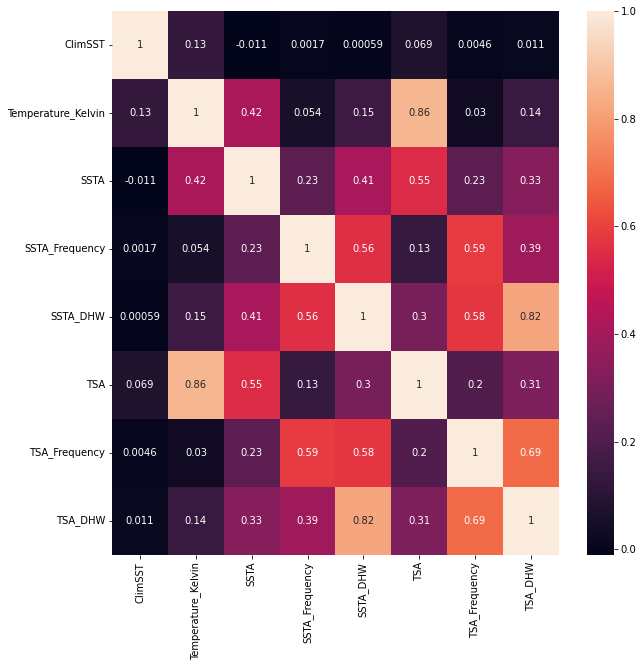

In [164]:
plt.figure(figsize=(10,10))
sns.heatmap(data=coral.corr().loc[['ClimSST', 'Temperature_Kelvin', 'SSTA', 'SSTA_Frequency', 
          'SSTA_DHW', 'TSA', 'TSA_Frequency', 'TSA_DHW'], ['ClimSST', 'Temperature_Kelvin',  'SSTA', 'SSTA_Frequency', 
          'SSTA_DHW', 'TSA', 'TSA_Frequency', 'TSA_DHW']], annot=True)

Some observations:

- ClimSST appears relatively uncorrelated. 
- Frequency and DHW are similar aggregations, so we somewhat unsurprisingly see cross-correlation between SSTA_ and TSA_ Frequency and DHW respectively. 
- TSA and Temperature_Kelvin are highly correlated
- SSTA_DHW and TSA_DHW are highly correlated.

My inital plan to address this is to use only ClimSST, Temperature_Kelvin, and TSA_DHW in the model. These three columns are relatively uncorrelated to one another, but had fairly high Cramér's phi values against the target. 

## Model Development

Now to assign the features and target columns:

In [174]:
X = coral[['Data_Source', 'Realm_Name', 'Distance_to_Shore', 'Exposure', 'Turbidity',
          'Cyclone_Frequency', 'Date_Year', 'Depth_m',
          'ClimSST', 'Temperature_Kelvin', 'Windspeed', 'TSA_DHW']]
y = coral['Bleaching_Severity']

I made some key decisions here, which I may revisit after training and scoring the model. 

First, I chose only one indicator of location. Whereas the original data breaks down location a variety of ways, including by ocean, by nearest country, by ecoregion, and by latitude and longitude, I have chosen to keep only one: Realm_Name- a categorical variable with 8 distinct values. I believe this feature strikes the best balance between specificity and simplicity. Some of the other location columns have 100+ categories! Having more than one location-based features would assign bias since this information will obviously cross-correlate.

Next, I have chosen to proceed with only the Date_Year column among the time information. I am not hoping to develop a time-series model so I fear including data to the day will risk overfitting. In a future iteration, I may use the Date_Month column as a proxy for season, or engineer a season column from it. I suspect that we will see an increase in coral bleaching over time, and hope that the year will capture that. Going forward, I may attempt to develop a time-series model that incorporates date-level data.

I also decided to drop Substrate_Name and Percent_Cover since they are missing so many values and have poor correlation with the target. 

In [218]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

Here I'll make dummy variables for the categorical features so that they can be used by the Random Forest model.

In [179]:
col_trans = make_column_transformer(
        (OneHotEncoder(), ['Data_Source', 'Realm_Name', 'Exposure']), 
        remainder = "passthrough", 
        verbose_feature_names_out = False)

onehot_df = col_trans.fit_transform(X)
X = pd.DataFrame(onehot_df, 
            columns = col_trans.get_feature_names_out())

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

We need to impute values for the missing data. On first pass, I'll use a SimpleImputer, the median, since no column is missing more than 5% of values. In a future iteration, I may attempt a k-nearest neighbors imputation instead.

In [204]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train, y_train),
             columns = X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

And at last, we're ready to apply the Random Forest Classifier! At first, I'll instantiate it with default parameters. After observing its performance, I'll run the classifier through a grid search cross-validation to tune the parameters.

In [223]:
random_forest_clf = RandomForestClassifier(oob_score=True)
random_forest_clf.fit(X_train_imputed, y_train)
print("Out of Bag Score: ", random_forest_clf.oob_score_)
print("Score on test data: ", random_forest_clf.score(X_test_imputed, y_test)) 

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  )


Out of Bag Score:  0.8906456953642384
Score on test data:  0.8908739739256398


89% is a pretty impressive result on the test data, and since the OOB score is about the same (in fact a bit lower), I'm not too concerned about overfitting. However, the default parameters don't set any limit to depth nor a minimum number of samples per leaf, so I'll go ahead with feature tuning to see if I can improve the result!

In [213]:
importances = random_forest_clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = X_train_imputed.columns[1:]

Out of curiosity, we can visualize which features contributed most to the model. It appears that Distance_to_Shore, Depth_m, Temperature_Kelvin, and Date_Year were the most useful predictors, but about 10 features played a significant role in the model.

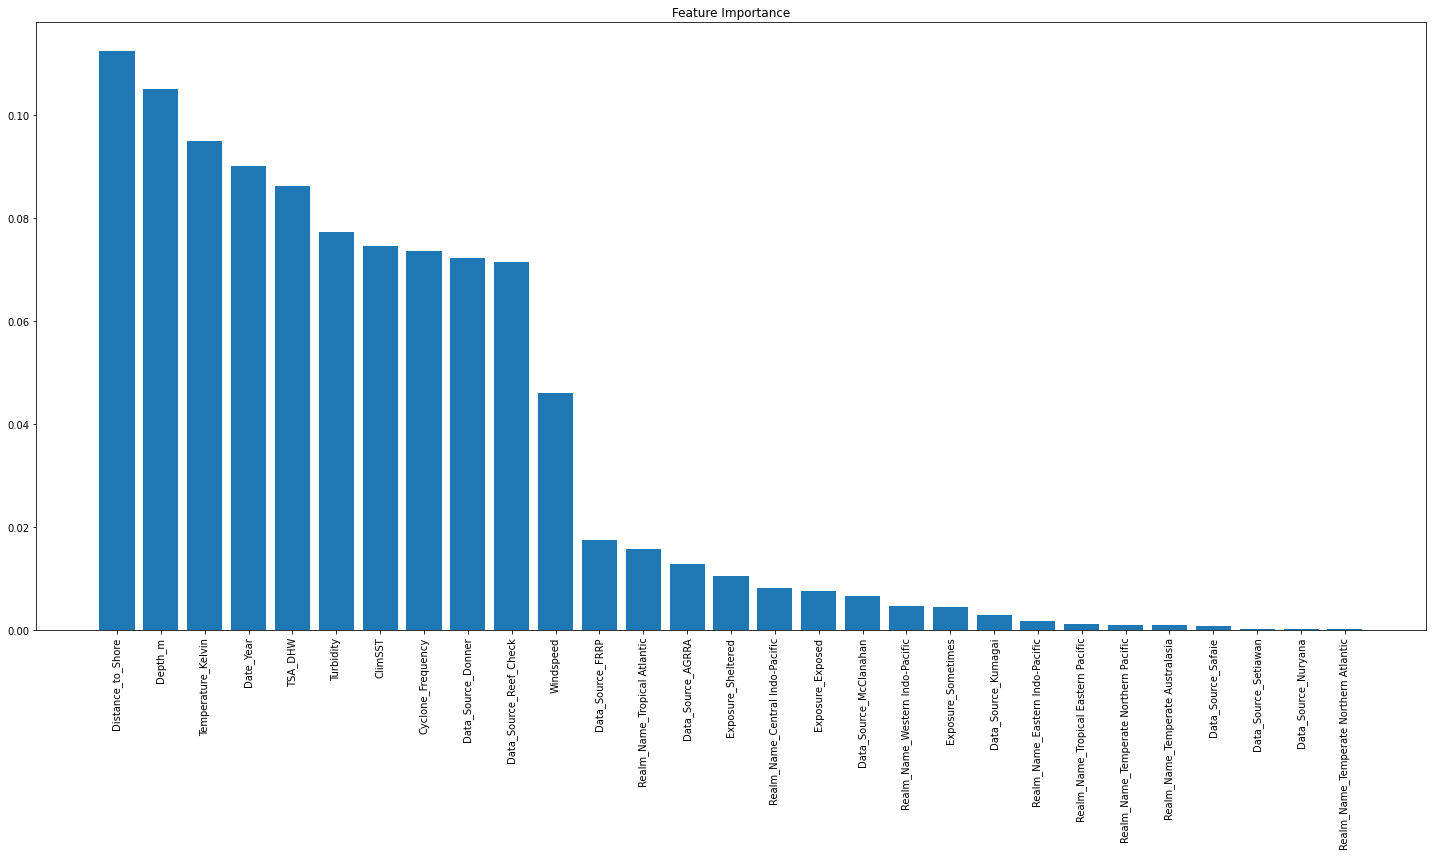

In [216]:
plt.figure(figsize=(20,12))
plt.title('Feature Importance')
plt.bar(range(X_train_imputed.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train_imputed.shape[1]), X_train_imputed.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [224]:
parameters = {'criterion':['gini', 'entropy'],
             'class_weight':[None, 'balanced'],
             'min_samples_split':[12, 30, 48],
             'max_depth': [x for x in range(5,11)],
             'min_samples_leaf': [x for x in range(3, 19, 3)]}

In [226]:
grid_forest = GridSearchCV(RandomForestClassifier(random_state=15), param_grid=parameters, 
                           scoring='accuracy', cv=5, n_jobs=-1)

grid_forest.fit(X_train_imputed,y_train)



/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using ver

https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/skle

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/skle

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/skle

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/skle

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.di

NameError: name 'grid_recall' is not defined

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/sashahalpern/miniconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using ver

In [228]:
best_estimator = grid_forest.best_estimator_
best_params = grid_forest.best_params_
best_score = grid_forest.best_score_

In [238]:
best_estimator

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=12, random_state=15)

In [230]:
best_score

0.8512831125827814

In [235]:
grid_importances = best_estimator.feature_importances_
sorted_indices = np.argsort(grid_importances)[::-1]
feat_labels = X_train_imputed.columns[1:]

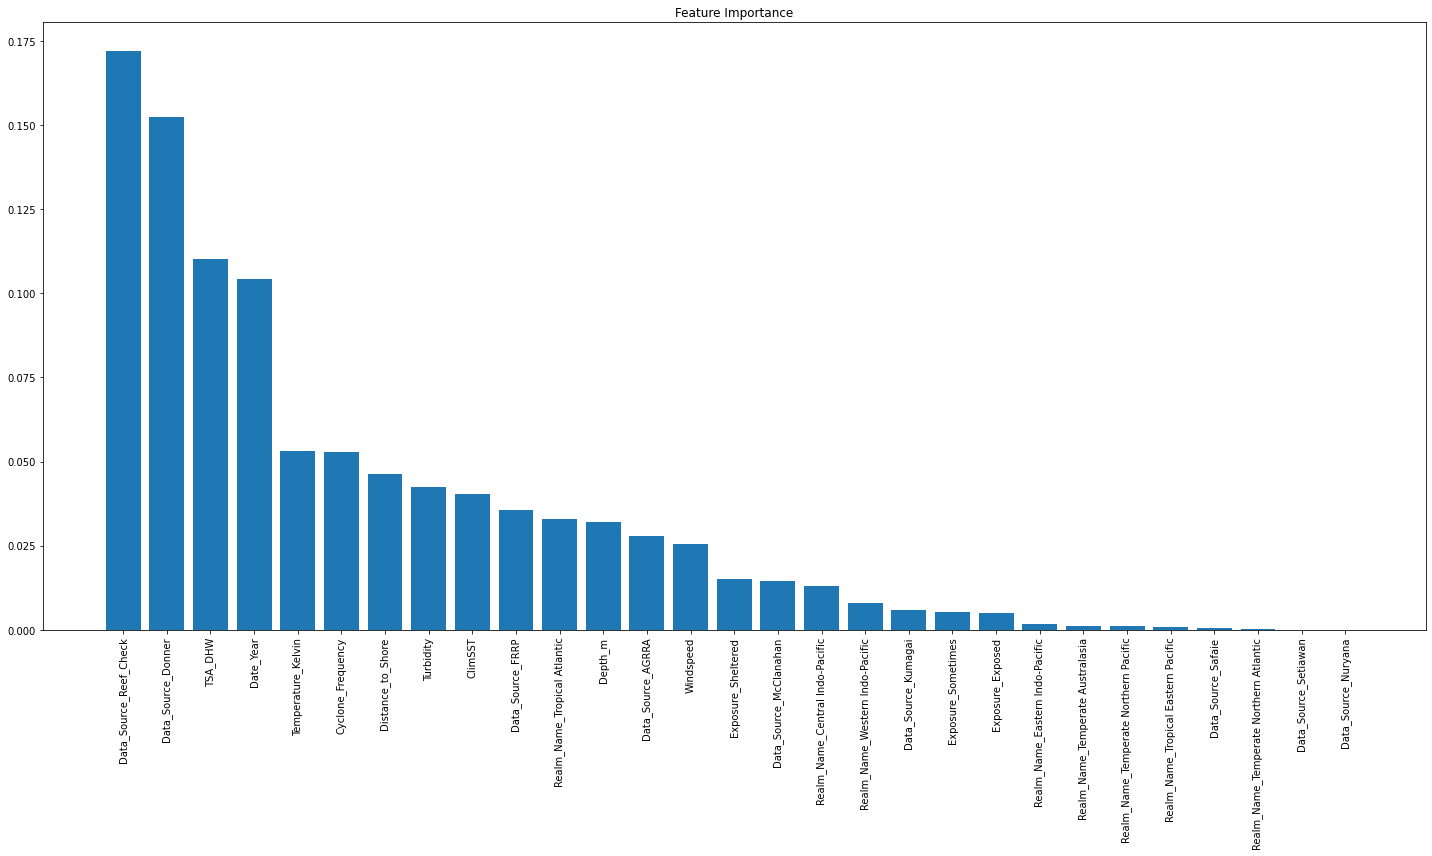

In [236]:
plt.figure(figsize=(20,12))
plt.title('Feature Importance')
plt.bar(range(X_train_imputed.shape[1]), grid_importances[sorted_indices], align='center')
plt.xticks(range(X_train_imputed.shape[1]), X_train_imputed.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

These hyperparameter options didn't improve the score beyond the default parameters of RandomForestClassifier. I'm interested in how the order of feature importance changed. In this model, Data_Source, especially Reef_Check and Donner, had much stronger bearing on the result.

For now, I'm satisfied with an accuracy score of 89%! 

In the future, I plan to revisit this model to improve the result even further. 

- I will do some research on hyperparameter tuning to see if there are other options I can search through to boost the result. 

- I'd like to experiment with including seasonality in the model. Date_Month had fairly low Cramér's phi correlation, but it would be interesting to see if it improved if the months were grouped into seasons.

- I will revisit the imputation where I filled all missing values with a median, and instead attempt a k-nearest neighbors approach.

- Experimenting with which temperature columns to include and exclude would be an interesting experiment, though I'm pretty satisfied with the performance of the 3 included in this model.

- A longer, but quite interesting, project would be to attempt to develop a regression model to predict the Percent_Bleaching instead of the categorical Bleaching_Severity.